In [3]:
USE_COLAB = True

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!pwd
!ls

/content
drive  sample_data


In [6]:
base_path = '/content/drive/MyDrive/Ai-Projects/'
project_dir = 'Faster-RCNN'
working_dir_path = f"{base_path+project_dir}"
print(working_dir_path)

/content/drive/MyDrive/Ai-Projects/Faster-RCNN


In [7]:
!ls {working_dir_path}

checkpoints		  object-detection-crowdai.tar.gz
object-detection-crowdai  README.md


In [8]:
import os
os.chdir(working_dir_path)

In [9]:
!pwd

/content/drive/MyDrive/Ai-Projects/Faster-RCNN


In [10]:
import torch
import torchvision
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import DataLoader, Dataset

In [11]:
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision.transforms.functional as F
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pickle
import pandas as pd
import glob as glob
import random
import os
import cv2
import numpy as np
from datetime import datetime
import sys

# 1. Create the dataset

## 1.1 Download the dataset

In [12]:
!wget -nc https://s3.amazonaws.com/udacity-sdc/annotations/object-detection-crowdai.tar.gz
!tar xf object-detection-crowdai.tar.gz

File ‘object-detection-crowdai.tar.gz’ already there; not retrieving.

^C


In [13]:
!pwd
!ls

/content/drive/MyDrive/Ai-Projects/Faster-RCNN
checkpoints		  object-detection-crowdai.tar.gz
object-detection-crowdai  README.md


## 1.2 Load the dataset

In [14]:
dataset_csv_path = os.path.join(working_dir_path,"object-detection-crowdai/labels.csv")
dataset_imgs_path = os.path.join(working_dir_path,"object-detection-crowdai")
print(dataset_csv_path)
print(dataset_imgs_path)

/content/drive/MyDrive/Ai-Projects/Faster-RCNN/object-detection-crowdai/labels.csv
/content/drive/MyDrive/Ai-Projects/Faster-RCNN/object-detection-crowdai


In [15]:
dataset_df = pd.read_csv(dataset_csv_path)

#### Preview Dataset

In [16]:
dataset_df.sample(5)

,xmin,xmax,ymin,ymax,Frame,Label,Preview URL
14878,643,523,704,683,1479500075079971495.jpg,Pedestrian,http://crowdai.com/images/MrBodqf7p6pb07BE/vis...
6175,1203,559,1363,657,1479498920503080167.jpg,Car,http://crowdai.com/images/S4iOyk0ty4xk3XlJ/vis...
15988,631,563,677,599,1479500180087279193.jpg,Car,http://crowdai.com/images/3WwcgGVMehTFmheg/vis...
45231,203,567,355,661,1479503976844100980.jpg,Car,http://crowdai.com/images/lx1S-HU6HJJLm5tv/vis...
50073,1241,570,1343,648,1479504400872609827.jpg,Car,http://crowdai.com/images/8RUk9u47m7iema9j/vis...


In [17]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72064 entries, 0 to 72063
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   xmin         72064 non-null  int64 
 1   xmax         72064 non-null  int64 
 2   ymin         72064 non-null  int64 
 3   ymax         72064 non-null  int64 
 4   Frame        72064 non-null  object
 5   Label        72064 non-null  object
 6   Preview URL  72064 non-null  object
dtypes: int64(4), object(3)
memory usage: 3.8+ MB


In [18]:
classes_names = list(dataset_df['Label'].unique())
print(f"Classes names  = {classes_names}")

Classes names  = ['Car', 'Truck', 'Pedestrian']


#### Load the images

In [19]:
images_paths = glob.glob(os.path.join(dataset_imgs_path,"*.jpg"))

In [20]:
print(images_paths[:2])

['/content/drive/MyDrive/Ai-Projects/Faster-RCNN/object-detection-crowdai/1479499580548628685.jpg', '/content/drive/MyDrive/Ai-Projects/Faster-RCNN/object-detection-crowdai/1479504298865323450.jpg']


In [21]:
print(f"Total Number of objects aka bounding boxes = {len(dataset_df)} ")
print(f"Total Number of images in the dataset = {len(images_paths)} ")

Total Number of objects aka bounding boxes = 72064 
Total Number of images in the dataset = 9420 


In [22]:
images_names = [os.path.basename(image_path) for image_path in images_paths]

In [23]:
print(images_names[:2])

['1479499580548628685.jpg', '1479504298865323450.jpg']


In [24]:
print(f"Total Number of images in the dataset = {len(images_names)} ")

Total Number of images in the dataset = 9420 


## 1.3 Prepare the dataset

### Create Augemntations Transformations Class

In [25]:
# class Augmentations():
#     '''
#         Define a random prob p for agumentation to be applied or not
#     '''
#     def get_prob(self):
#         np.random.choice([True, False], replace=False, p=[0.5,0.5])

#     '''
#         Increase Contrast with Value of 2
#     '''
#     def random_contrast_adjust(self, image, enable=None):
#         enable = self.get_prob() if enable is None else enable
#         return F.adjust_contrast(image,2) if enable else image

#     '''
#         Increase Brightness with Value of 2
#     '''
#     def random_brightness_adjust(self, image, enable=None):
#         enable = enable = self.get_probability() if enable is None else enable
#         return F.adjust_brightness(image,2) if enable else image


#     '''
#         Random Horizontal flip
#     '''
#     def random_hflip(self, image, boxes, enable=None):
#         enable = self.get_probability() if enable is None else enable
#         if enable:
#           #flip image
#           new_image = F.hflip(image)

#           #flip boxes
#           new_boxes = boxes.clone()
#           new_boxes[:, 0] = image.shape[2] - boxes[:, 0]  # image width - xmin
#           new_boxes[:, 2] = image.shape[2] - boxes[:, 2]  # image_width - xmax
#           new_boxes = new_boxes[:, [2, 1, 0, 3]]          # Interchange the xmin and xmax due to mirroring
#           return new_image, new_boxes
#         else:
#           return image, boxes


In [26]:
class Augmentations:
    """
    Tensor-based augmentations for object detection images.
    All images are expected as PyTorch tensors with shape [C,H,W], values in [0,1].
    """

    def get_prob(self, p=0.5):
        """Return True with probability p, False otherwise"""
        return torch.rand(1).item() < p

    def random_contrast_adjust(self, image, enable=None, factor=2.0):
        """
        Adjust contrast for tensor image [C,H,W].
        image: torch.FloatTensor [C,H,W] values in [0,1]
        factor: contrast factor, >1 increases contrast
        """
        enable = self.get_prob() if enable is None else enable
        if enable:
            mean = image.mean(dim=[1,2], keepdim=True)   # mean per channel
            image = (image - mean) * factor + mean
            image = image.clamp(0,1)
        return image

    def random_brightness_adjust(self, image, enable=None, factor=0.5):
        """
        Adjust brightness for tensor image [C,H,W].
        factor: maximum brightness adjustment
        """
        enable = self.get_prob() if enable is None else enable
        if enable:
            adjustment = (torch.rand(1).item() * 2 - 1) * factor  # random in [-factor, +factor]
            image = (image + adjustment).clamp(0,1)
        return image

    # def random_hflip(self, image, boxes, enable=None):
    #     """
    #     Random horizontal flip for tensor image and bounding boxes
    #     image: torch.FloatTensor [C,H,W]
    #     boxes: torch.FloatTensor [N,4] with [xmin,ymin,xmax,ymax]
    #     """
    #     enable = self.get_prob() if enable is None else enable
    #     if enable:
    #         # flip image
    #         image = torch.flip(image, dims=[2])  # flip width dimension

    #         # flip boxes
    #         new_boxes = boxes.clone()
    #         width = image.shape[2]
    #         new_boxes[:, 0] = width - boxes[:, 2]  # new xmin = width - old xmax
    #         new_boxes[:, 2] = width - boxes[:, 0]  # new xmax = width - old xmin
    #         return image, new_boxes
        # return image, boxes

In [27]:
def transform_img(image):
    '''
        Convert OpenCV Image to RGB Image then to Tensor and Normalzie Values
    '''
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image /= 255.0
    image = torch.from_numpy(image).permute(2,0,1)

    return image

### Create Dataset Class

In [28]:
class Crowd_Dataset(Dataset):
    def __init__(self, images_path, labels_path,classes=None, transforms=None):
        super().__init__()
        print("Preparing the dataset...")
        self.removed_images = []

        # 1. Store passed arguments
        self.images_dir_path = images_path
        self.labels_path = labels_path
        self.classes = classes
        self.transforms = transforms

        # 2. Read dataset info as dataframe
        self.dataset_info_df = pd.read_csv(labels_path)

        # 3. Convert numeric columns
        numeric_columns = ['xmin', 'ymin', 'xmax', 'ymax']
        for col in numeric_columns:
            if col in self.dataset_info_df.columns:
                self.dataset_info_df[col] = pd.to_numeric(self.dataset_info_df[col], errors='coerce') # invalid parsing convert to NaN

        # 4. Handle NaN values if exists
        if self.dataset_info_df[numeric_columns].isna().any().any():  # Check if (any) columns has (any) NaN
            print("Warning: Some bounding box coordinates could not be converted to numbers.")

        nan_rows_count = self.dataset_info_df[self.dataset_info_df[numeric_columns].isna().any(axis=1)].shape[0] # Rows where any columns is NaN
        print(f"Dropping {nan_rows_count} rows with NaN coordinates")

        self.dataset_info_df.dropna(subset=numeric_columns) # Drop rows where numeric columns has NaN values
        self.dataset_info_df.reset_index(drop=True) # Reset indicies to fix dropped rows indicies
        print(f"New Shape after dropping NaNs: {self.dataset_info_df.shape}")

        # 5. Check if header row is included with data
        header_row = self.dataset_info_df[self.dataset_info_df['Label'] == 'Label']
        if not header_row.empty:
                print(f"Found {len(header_row)} rows where 'Label' is literally 'Label'. These are likely header rows.")
                self.dataset_info_df = self.dataset_info_df[self.dataset_info_df['Label'] != 'Label'] # Keep only data rows which are not accidently header row
                self.dataset_info_df.reset_index(drop=True) # Reset indicies to fix dropped rows indicies

        # 6. Extract classes if not provided
        if self.classes is None:
            self.classes = sorted(self.dataset_info_df['Label'].unique().tolist())
        else:
            self.classes = classes
        print(f"Classes in dataset: {self.classes}")

        # 7. Create a list of images names in sorted order
        self.images_paths = glob.glob(f"{self.images_dir_path}/*.jpg")
        all_images_names = [image_path.split(os.path.sep)[-1] for image_path in self.images_paths] # /content/example/dataset/img_1.jpg
        self.all_images_names = sorted(all_images_names)
        print(f"Found {len(self.all_images_names)} images in directory")

        # 8. Encode Labels(Strings) To Labels(int) as indicies
        for i in range(len(self.dataset_info_df)): # Loop through all rows
            label_rowi = self.dataset_info_df.loc[i, 'Label']
            try:
                self.dataset_info_df.loc[i, 'Label'] = self.classes.index(label_rowi)
            except ValueError:
                if label_rowi != 'Label':  # Skip actual header rows
                    print(f"Warning: Label '{label_rowi}' not found in classes list. Adding it.")
                    self.classes.append(label_rowi) # Add New Class
                    self.dataset_info_df.loc[i, 'Label'] = self.classes.index(label_rowi)

        # 9. Filter the dataset
        self.filter_dataset() # Filter the dataset by removing images with no labels and incorrect bounding boxes

        print("Dataset preparation Done.")



    '''
        Filter the dataset by removing images with no labels and incorrect bounding boxes
    '''
    def filter_dataset(self):
        # 1. Filter empty scenes images with no labels == Not in the dataset frame but in dataset dir
        for image_file in self.all_images_names.copy():
            if image_file not in self.dataset_info_df['Frame'].values:
                self.all_images_names.remove(image_file)
                self.removed_images.append(image_file)
        print(f"Images removed with no labels: {len(self.removed_images)}")


        # 2. Filter out rows with incorrect bboxes

        for col in ['xmin', 'ymin', 'xmax', 'ymax']:  # Ensure all coordinates are numeric before comparison
            if self.dataset_info_df[col].dtype == 'object':  # If column contains strings
                self.dataset_info_df[col] = pd.to_numeric(self.dataset_info_df[col], errors='coerce')
        self.dataset_info_df = self.dataset_info_df.reset_index(drop=True)   # Reset index to avoid KeyError when accessing rows

        valid_boxes_mask = (                                                                    # Find rows with incorrect bounding boxes (e.g. xmax=xmin)
                        (self.dataset_info_df['xmax'] - self.dataset_info_df['xmin'] > 0) &
                        (self.dataset_info_df['ymax'] - self.dataset_info_df['ymin'] > 0)
                        )                                                                       # bool series with n=nrows with true where condition applied
        invalid_boxes_count = (~valid_boxes_mask).sum() # Number of invalid bboxes
        print(f"Number of rows with incorrect bounding boxes: {invalid_boxes_count}")

        self.dataset_info_df = self.dataset_info_df[valid_boxes_mask] # Filter out rows with invalid boxes
        self.dataset_info_df = self.dataset_info_df.reset_index(drop=True) # Reset index again after filtering

        print(f"Final dataset shape: {self.dataset_info_df.shape}")
        print(f"Final number of images: {len(self.all_images_names)}")



    def __getitem__(self, idx):
        # Dict for ground truth labels and bboxes
        target = {}

        # Read input image
        image_name = self.all_images_names[idx]
        image_path = os.path.join(self.images_dir_path, image_name)
        image = cv2.imread(image_path)
        image_tensor = transform_img(image)    # Normlaize and convert to tensor

        # Get Ground Truth Information for the image
        gt_info = self.dataset_info_df[self.dataset_info_df['Frame'] == image_name]

        # Extact Labels and bboxes and convert to tensors
        boxes = torch.Tensor(gt_info[['xmin', 'ymin', 'xmax', 'ymax']].values).float()
        labels = torch.LongTensor(gt_info['Label'].values.tolist())

        # Apply Random Augmentations
        if self.transforms != None:
            image_tensor = self.transforms.random_contrast_adjust(image_tensor, enable=True)
            image_tensor = self.transforms.random_brightness_adjust(image_tensor, enable=True)
            # image_tensor, boxes = self.transforms.random_hflip(image_tensor, boxes, enable=True)


        target["boxes"] = boxes     # Hint: Shape -> [N, 4] with N = Number of Boxes
        target["labels"] = labels   # Hint: Shape -> [N] with N = Number of Boxes

        return image_tensor, target


    def __len__(self):
        return len(self.all_images_names)


In [29]:
import matplotlib.patches as patches

def plot_image(img, boxes, scores, labels, dataset, save_path=None):
  '''
  Function that draws the BBoxes, scores, and labels on the image.

  inputs:
    img: input-image as numpy.array (shape: [H, W, C])
    boxes: list of bounding boxes (Format [N, 4] => N times [xmin, ymin, xmax, ymax])
    scores: list of conf-scores (Format [N] => N times confidence-score between 0 and 1)
    labels: list of class-prediction (Format [N] => N times an number between 0 and _num_classes-1)
    dataset: list of all classes e.g. ["background", "class1", "class2", ..., "classN"] => Format [N_classes]
  '''

  cmap = plt.get_cmap("tab20b")
  class_labels = np.array(dataset)
  colors = [cmap(i) for i in np.linspace(0, 1, len(class_labels))]
  height, width, _ = img.shape
  # Create figure and axes
  fig, ax = plt.subplots(1, figsize=(16, 8))
  # Display the image
  ax.imshow(img)
  for i, box in enumerate(boxes):
    class_pred = labels[i]
    conf = scores[i]
    width = box[2] - box[0] # [x_min,y_min,x_max,y_max]
    height = box[3] - box[1]
    rect = patches.Rectangle(
        (box[0], box[1]),
        width,
        height,
        linewidth=2,
        edgecolor=colors[int(class_pred)],
        facecolor="none",
    )
    # Add the patch to the Axes
    ax.add_patch(rect)
    plt.text(
        box[0], box[1],
        s=class_labels[int(class_pred)] + " " + str(int(100*conf)) + "%",
        color="white",
        verticalalignment="top",
        bbox={"color": colors[int(class_pred)], "pad": 0},
    )

  # Used to save inference phase results
  if save_path is not None:
    plt.savefig(save_path)

  plt.show()

In [30]:
dataset = Crowd_Dataset(dataset_imgs_path, dataset_csv_path, classes_names, transforms=Augmentations())

Preparing the dataset...
Dropping 0 rows with NaN coordinates
New Shape after dropping NaNs: (72064, 7)
Classes in dataset: ['Car', 'Truck', 'Pedestrian']
Found 9420 images in directory
Images removed with no labels: 202
Number of rows with incorrect bounding boxes: 52339
Final dataset shape: (19725, 7)
Final number of images: 9218
Dataset preparation Done.


Image index:  6378
Boxes = [[356. 464. 556. 598.]
 [514. 596. 567. 597.]
 [209. 356. 567. 657.]
 [  5. 131. 585. 683.]]


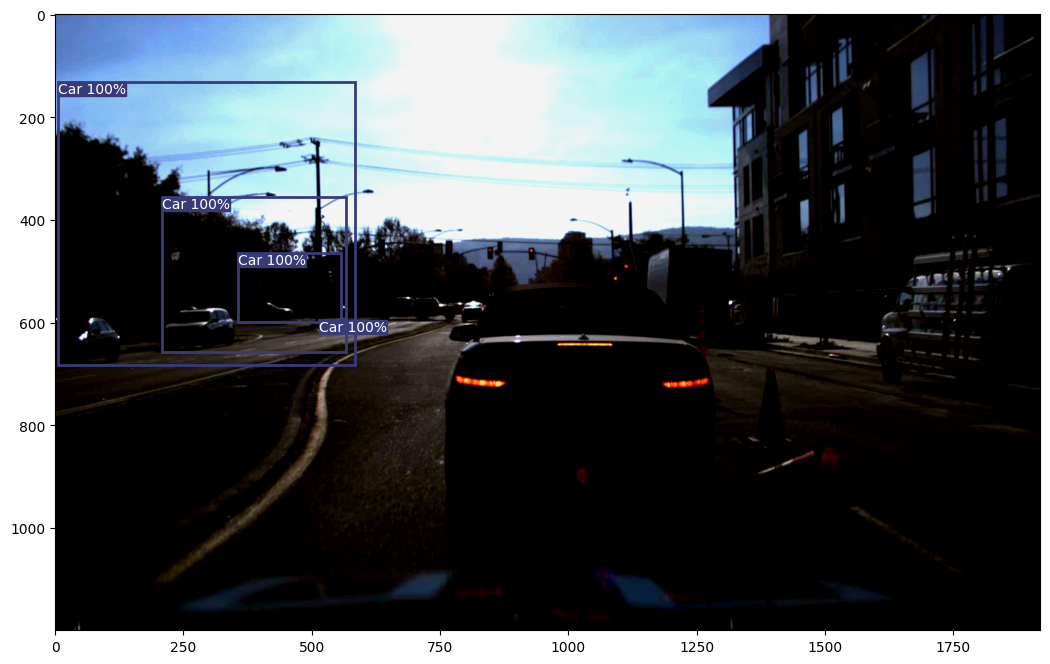

Image index:  3568
Boxes = []


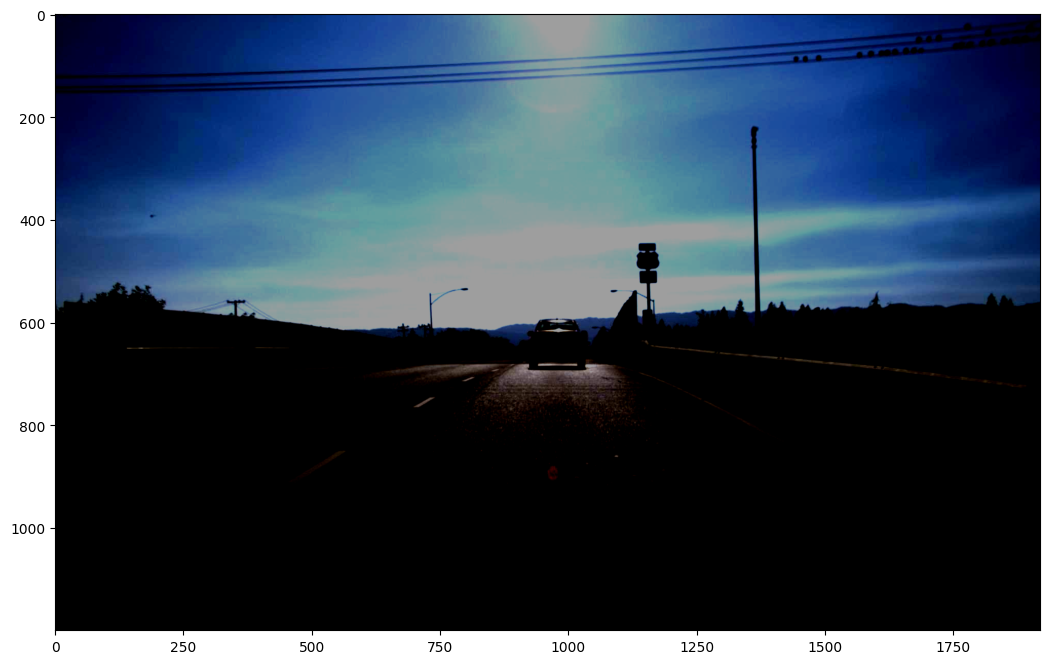

Image index:  691
Boxes = []


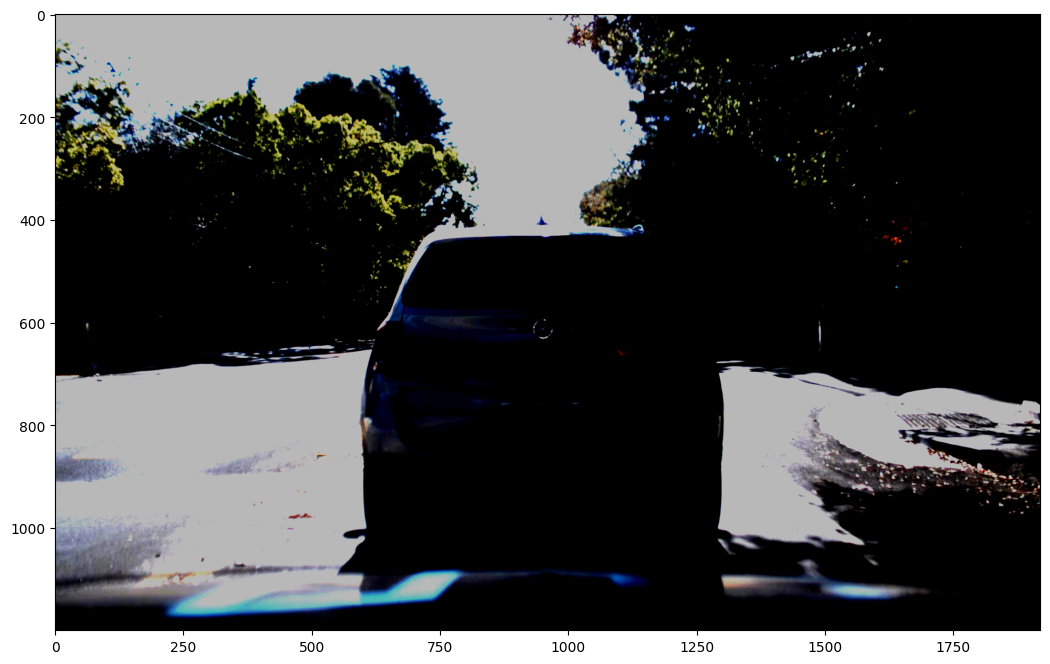

Image index:  5319
Boxes = [[151. 562. 519. 820.]]


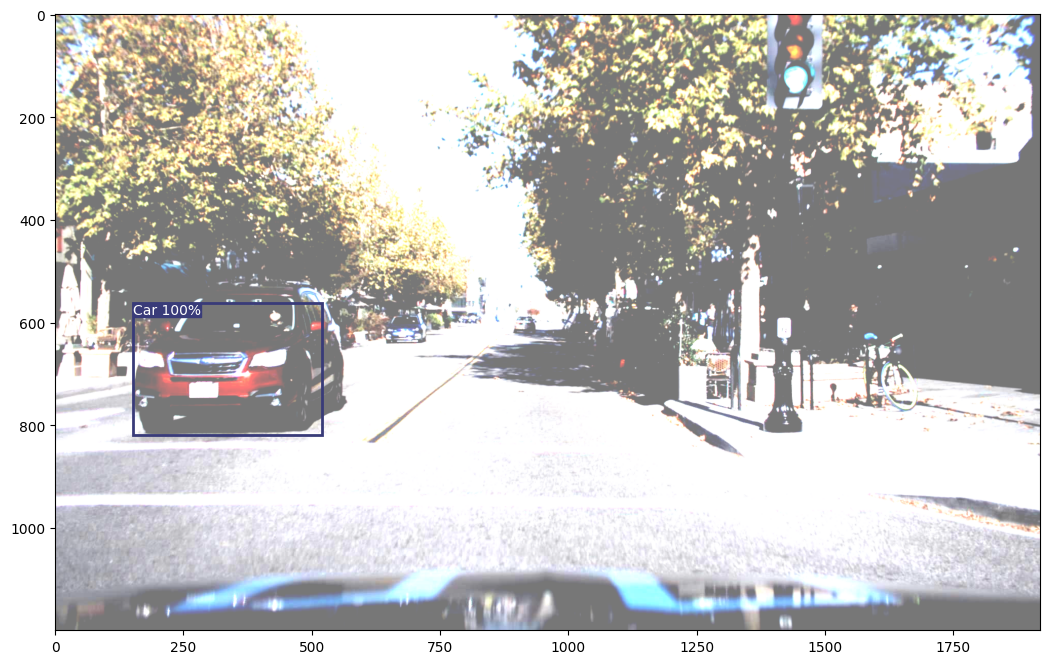

Image index:  4446
Boxes = [[295. 632. 503. 751.]
 [  0. 327. 356. 953.]
 [238. 352. 522. 601.]]


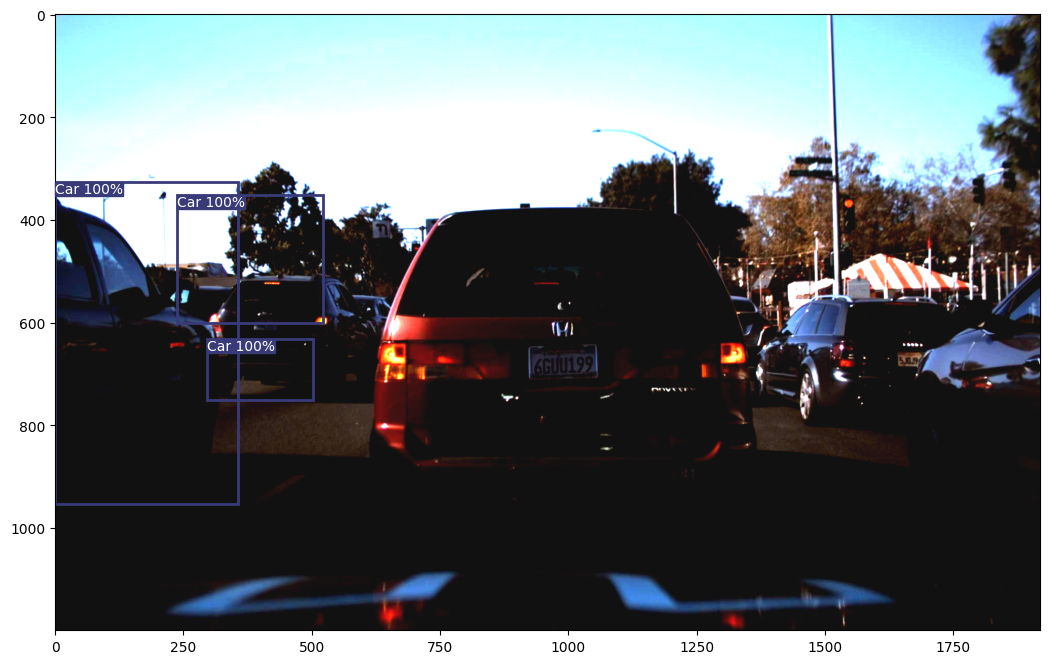

In [31]:
crowdai = ["Car", "Truck", "Pedestrian"]
num_images = 5

for _ in range(num_images):
  x = random.randint(0, (dataset.__len__()-1))
  img, target = dataset.__getitem__(x)
  img = img.permute(1,2,0).numpy()
  boxes = target['boxes'].numpy()
  labels = target['labels'].numpy()
  scores = [1]*len(labels)
  print("Image index: ", x)
  print(f"Boxes = {boxes}")
  plot_image(img, boxes, scores, labels, crowdai)

# 2. Create Model

In [32]:
# Hyperparameters
TEST_SIZE = 0.2

NUM_EPOCHS = 5

LR = 0.005
LR_MOMENTUM=0.9
LR_DECAY_RATE=0.0005

LR_SCHED_STEP_SIZE = 0.1
LR_SCHED_GAMMA = 0.1

BATCH_SIZE = 16

NUM_TEST_IMAGES = 5
NMS_THRESH = 0.01


In [33]:
crowdai = ["Background", "Car", "Truck", "Pedestrian"]

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(min_size=300, max_size=480, pretrained=True)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [34]:
print(model)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(300,), max_size=480, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(i

In [35]:
in_features = model.roi_heads.box_predictor.cls_score.in_features
print(in_features)

1024


In [36]:
num_classes = len(crowdai)
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(300,), max_size=480, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(i

In [37]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params,LR, momentum=LR_MOMENTUM, weight_decay=LR_DECAY_RATE)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, \
                                                step_size=LR_SCHED_STEP_SIZE, \
                                                gamma=LR_SCHED_GAMMA)

In [38]:
# split the dataset in train and test set
dataset = Crowd_Dataset(dataset_imgs_path, dataset_csv_path, crowdai, transforms=Augmentations())
dataset_test = Crowd_Dataset(dataset_imgs_path, dataset_csv_path, crowdai, transforms=None)

SEED = 42
torch.manual_seed(SEED)

indices = torch.randperm(len(dataset)).tolist()

test_size = int(len(dataset) * TEST_SIZE)
dataset = torch.utils.data.Subset(dataset, indices[:-test_size])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-test_size:])

def collate_fn(batch):
  return tuple(zip(*batch))

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
  dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2,
  collate_fn=collate_fn) # Dataloader --> (B, size(sample)) example: (B, 224, 224, 3) --> 16 * (224,224,3)

data_loader_test = torch.utils.data.DataLoader(
  dataset_test, batch_size=1, shuffle=False, num_workers=2,
  collate_fn=collate_fn)

Preparing the dataset...
Dropping 0 rows with NaN coordinates
New Shape after dropping NaNs: (72064, 7)
Classes in dataset: ['Background', 'Car', 'Truck', 'Pedestrian']
Found 9420 images in directory
Images removed with no labels: 202
Number of rows with incorrect bounding boxes: 52339
Final dataset shape: (19725, 7)
Final number of images: 9218
Dataset preparation Done.
Preparing the dataset...
Dropping 0 rows with NaN coordinates
New Shape after dropping NaNs: (72064, 7)
Classes in dataset: ['Background', 'Car', 'Truck', 'Pedestrian']
Found 9420 images in directory
Images removed with no labels: 202
Number of rows with incorrect bounding boxes: 52339
Final dataset shape: (19725, 7)
Final number of images: 9218
Dataset preparation Done.


In [39]:
'''
  Helper: extract a single scalar loss tensor from model output
'''

def _extract_loss(losses):
    """
    Convert model output 'losses' to a single scalar torch.Tensor.
    Accepts:
      - torch.Tensor
      - dict of tensors -> sum of values
      - list/tuple of tensors or dicts -> sum of all
    Raises TypeError for unsupported types.
    """
    if isinstance(losses, torch.Tensor):
        return losses

    # dict -> sum values (values may be tensors or nested dicts)
    if isinstance(losses, dict):
        total = None
        for v in losses.values():
            if isinstance(v, dict):
                t = _extract_loss(v)
            elif isinstance(v, torch.Tensor):
                t = v
            else:
                raise TypeError(f"Unsupported dict value type in losses: {type(v)}")
            total = t if total is None else total + t
        if total is None:
            raise ValueError("Empty losses dict")
        return total

    # list/tuple -> sum items (each can be tensor or dict)
    if isinstance(losses, (list, tuple)):
        total = None
        for item in losses:
            if isinstance(item, torch.Tensor):
                t = item
            elif isinstance(item, dict):
                t = _extract_loss(item)
            else:
                raise TypeError(f"Unsupported item type in losses list: {type(item)}")
            total = t if total is None else total + t
        if total is None:
            raise ValueError("Empty losses list/tuple")
        return total

    raise TypeError(f"Unsupported losses type: {type(losses)}")

In [40]:
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()  # ensure training mode
    train_loss_list = []

    tqdm_bar = tqdm(data_loader, total=len(data_loader))
    for idx, data in enumerate(tqdm_bar):
        optimizer.zero_grad()

        images, targets = data  # images: list of tensors, targets: list of dicts

        # Move data to device
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward -> may return dict, list, tensor, etc.
        losses = model(images, targets) # {loss_bbox: 0.2, loss_cls: 0.5} ,

        # Robust extraction to single tensor
        loss = _extract_loss(losses) # 0.7

        # record and backward
        train_loss_list.append(loss.item())

        loss.backward()
        optimizer.step()

        tqdm_bar.set_description(desc=f"BATCH {idx} Training Loss: {loss:.3f}")

    return train_loss_list



def evaluate(model, data_loader_test, device):
  # save previous training state and set to train() so model returns losses
  was_training = model.training
  model.train()

  val_loss_list = []
  tqdm_bar = tqdm(data_loader_test, total=len(data_loader_test))

  for i, data in enumerate(tqdm_bar):
      images, targets = data

      # Move to device
      images = [image.to(device) for image in images]
      targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

      # Compute losses without gradient
      with torch.no_grad():
          losses = model(images, targets)

      loss = _extract_loss(losses)
      val_loss_list.append(loss.item())

      tqdm_bar.set_description(desc=f"Validation Loss: {loss:.4f}")

  # restore previous training/eval mode
  if not was_training:
      model.eval()

  return val_loss_list

OUTPUT_DIR = os.path.join(working_dir_path,'checkpoints')
def plot_loss(train_loss, valid_loss, output_dir=OUTPUT_DIR):
    # plot training losses (per-iteration)
    fig1, ax1 = plt.subplots()
    ax1.plot(train_loss)
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Training Loss')
    ax1.set_title('Training Loss (per iteration)')
    fig1.savefig(f"{output_dir}/train_loss.png")
    plt.close(fig1)

    # plot validation losses (per-iteration)
    fig2, ax2 = plt.subplots()
    ax2.plot(valid_loss)
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Validation Loss')
    ax2.set_title('Validation Loss (per iteration)')
    fig2.savefig(f"{output_dir}/valid_loss.png")
    plt.close(fig2)

In [41]:
# find latest saved chcekpoint
checkpoint_files = [f for f in os.listdir(OUTPUT_DIR) if f.endswith('.pth')]
if checkpoint_files:
    # Last ckpt file
    checkpoint_files.sort()
    latest_checkpoint = os.path.join(OUTPUT_DIR, checkpoint_files[-1])

    # Load the ckpt
    checkpoint = torch.load(latest_checkpoint)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    loss_dict = checkpoint['loss_dict']
else:
    start_epoch = 0
    loss_dict = {'train_loss': [], 'valid_loss': []}

In [42]:
'''
Train the model over all epochs
'''
for epoch in range(start_epoch, NUM_EPOCHS):
  print("----------Epoch {}----------".format(epoch+1))

  # Train the model for one epoch
  train_loss_list = train_one_epoch(model, optimizer, data_loader, device, epoch)
  loss_dict['train_loss'].extend(train_loss_list)

  lr_scheduler.step()

  # Run evaluation
  valid_loss_list = evaluate(model, data_loader_test, device)
  loss_dict['valid_loss'].extend(valid_loss_list)

  # Svae the model ckpt after every epoch
  ckpt_file_name = f"{OUTPUT_DIR}/epoch_{epoch+1}_model.pth"
  torch.save({
    'epoch': epoch+1,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss_dict': loss_dict
  }, ckpt_file_name)

  # NOTE: The losses are accumulated over all iterations
  plot_loss(loss_dict['train_loss'], loss_dict['valid_loss'])

# Store the losses after the training in a pickle
with open(f"{OUTPUT_DIR}/loss_dict.pkl", "wb") as file:
    pickle.dump(loss_dict, file)

print("Training Finished !")

----------Epoch 1----------


Validation Loss: 0.3443: 100%|██████████| 1843/1843 [02:10<00:00, 14.07it/s]


----------Epoch 2----------


Validation Loss: 0.3074: 100%|██████████| 1843/1843 [02:11<00:00, 13.99it/s]


----------Epoch 3----------


Validation Loss: 0.3492: 100%|██████████| 1843/1843 [02:10<00:00, 14.08it/s]


----------Epoch 4----------


Validation Loss: 0.2907: 100%|██████████| 1843/1843 [02:09<00:00, 14.23it/s]


----------Epoch 5----------


Validation Loss: 0.3065: 100%|██████████| 1843/1843 [02:12<00:00, 13.90it/s]


Training Finished !
